<a href="https://colab.research.google.com/github/dakyommii/study/blob/main/forkProject/drawing2fork.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import torch
import torch.nn as nn
import torch.optim as optim
from torch.autograd import Variable
import torch.utils.data as data
import random
from torchvision import transforms

from PIL import Image

import os , itertools
print(os.listdir("/content/drive/MyDrive/data"))

import matplotlib.pyplot as plt

['testB', 'testA', 'trainB', 'trainA']


In [2]:
params = {
    'batch_size':1,
    'input_size':256,
    'resize_scale':286,
    'crop_size':256,
    'fliplr':True,
    #model params
    'num_epochs':100,
    'decay_epoch':100,
    'ngf':32,   #number of generator filters
    'ndf':64,   #number of discriminator filters
    'num_resnet':6, #number of resnet blocks
    'lrG':0.0002,    #learning rate for generator
    'lrD':0.0002,    #learning rate for discriminator
    'beta1':0.5 ,    #beta1 for Adam optimizer
    'beta2':0.999 ,  #beta2 for Adam optimizer
    'lambdaA':10 ,   #lambdaA for cycle loss
    'lambdaB':10  ,  #lambdaB for cycle loss
}

In [3]:
data_dir = "/content/drive/MyDrive/data"
def to_np(x):
    return x.data.cpu().numpy()
def plot_train_result(real_image, gen_image, recon_image, epoch, save=False,  show=True, fig_size=(15, 15)):
    fig, axes = plt.subplots(2, 3, figsize=fig_size)
    imgs = [to_np(real_image[0]), to_np(gen_image[0]), to_np(recon_image[0]),
            to_np(real_image[1]), to_np(gen_image[1]), to_np(recon_image[1])]
    for ax, img in zip(axes.flatten(), imgs):
        ax.axis('off')
        #ax.set_adjustable('box-forced')
        # Scale to 0-255
        img = img.squeeze()
        img = (((img - img.min()) * 255) / (img.max() - img.min())).transpose(1, 2, 0).astype(np.uint8)
        ax.imshow(img, cmap=None, aspect='equal')
    plt.subplots_adjust(wspace=0, hspace=0)

    title = 'Epoch {0}'.format(epoch + 1)
    fig.text(0.5, 0.04, title, ha='center')

    # save figure
    if save:
        save_fn = 'Result_epoch_{:d}'.format(epoch+1) + '.png'
        plt.savefig(save_fn)

    if show:
        plt.show()
    else:
        plt.close()

In [4]:
class ImagePool():
    def __init__(self, pool_size):
        self.pool_size = pool_size
        if self.pool_size > 0:
            self.num_imgs = 0
            self.images = []

    def query(self, images):
        if self.pool_size == 0:
            return images
        return_images = []
        for image in images.data:
            image = torch.unsqueeze(image, 0)
            if self.num_imgs < self.pool_size:
                self.num_imgs = self.num_imgs + 1
                self.images.append(image)
                return_images.append(image)
            else:
                p = random.uniform(0, 1)
                if p > 0.5:
                    random_id = random.randint(0, self.pool_size-1)
                    tmp = self.images[random_id].clone()
                    self.images[random_id] = image
                    return_images.append(tmp)
                else:
                    return_images.append(image)
        return_images = Variable(torch.cat(return_images, 0))
        return return_images

In [5]:
class DatasetFromFolder(data.Dataset):
    def __init__(self, image_dir, subfolder='train', transform=None, resize_scale=None, crop_size=None, fliplr=False):
        super(DatasetFromFolder, self).__init__()
        self.input_path = os.path.join(image_dir, subfolder)
        self.image_filenames = [x for x in sorted(os.listdir(self.input_path))]
        self.transform = transform
        
        self.resize_scale = resize_scale
        self.crop_size = crop_size
        self.fliplr = fliplr

    def __getitem__(self, index):
        # Load Image
        img_fn = os.path.join(self.input_path, self.image_filenames[index])
        img = Image.open(img_fn).convert('RGB')

        # preprocessing
        if self.resize_scale:
            img = img.resize((self.resize_scale, self.resize_scale), Image.BILINEAR)

        if self.crop_size:
            x = random.randint(0, self.resize_scale - self.crop_size + 1)
            y = random.randint(0, self.resize_scale - self.crop_size + 1)
            img = img.crop((x, y, x + self.crop_size, y + self.crop_size))
        if self.fliplr:
            if random.random() < 0.5:
                img = img.transpose(Image.FLIP_LEFT_RIGHT)

        if self.transform is not None:
            img = self.transform(img)

        return img

    def __len__(self):
        return len(self.image_filenames)


In [6]:
class ConvBlock(torch.nn.Module):
    def __init__(self,input_size,output_size,kernel_size=3,stride=2,padding=1,activation='relu',batch_norm=True):
        super(ConvBlock,self).__init__()
        self.conv = torch.nn.Conv2d(input_size,output_size,kernel_size,stride,padding)
        self.batch_norm = batch_norm
        self.bn = torch.nn.InstanceNorm2d(output_size)
        self.activation = activation
        self.relu = torch.nn.ReLU(True)
        self.lrelu = torch.nn.LeakyReLU(0.2,True)
        self.tanh = torch.nn.Tanh()
    def forward(self,x):
        if self.batch_norm:
            out = self.bn(self.conv(x))
        else:
            out = self.conv(x)
        
        if self.activation == 'relu':
            return self.relu(out)
        elif self.activation == 'lrelu':
            return self.lrelu(out)
        elif self.activation == 'tanh':
            return self.tanh(out)
        elif self.activation == 'no_act':
            return out

In [7]:
class DeconvBlock(torch.nn.Module):
    def __init__(self,input_size,output_size,kernel_size=3,stride=2,padding=1,output_padding=1,activation='relu',batch_norm=True):
        super(DeconvBlock,self).__init__()
        self.deconv = torch.nn.ConvTranspose2d(input_size,output_size,kernel_size,stride,padding,output_padding)
        self.batch_norm = batch_norm
        self.bn = torch.nn.InstanceNorm2d(output_size)
        self.activation = activation
        self.relu = torch.nn.ReLU(True)
    def forward(self,x):
        if self.batch_norm:
            out = self.bn(self.deconv(x))
        else:
            out = self.deconv(x)
        if self.activation == 'relu':
            return self.relu(out)
        elif self.activation == 'lrelu':
            return self.lrelu(out)
        elif self.activation == 'tanh':
            return self.tanh(out)
        elif self.activation == 'no_act':
            return out

In [8]:
class ResnetBlock(torch.nn.Module):
    def __init__(self,num_filter,kernel_size=3,stride=1,padding=0):
        super(ResnetBlock,self).__init__()
        conv1 = torch.nn.Conv2d(num_filter,num_filter,kernel_size,stride,padding)
        conv2 = torch.nn.Conv2d(num_filter,num_filter,kernel_size,stride,padding)
        bn = torch.nn.InstanceNorm2d(num_filter)
        relu = torch.nn.ReLU(True)
        pad = torch.nn.ReflectionPad2d(1)
        
        self.resnet_block = torch.nn.Sequential(
            pad,
            conv1,
            bn,
            relu,
            pad,
            conv2,
            bn
            )
    def forward(self,x):
        out = self.resnet_block(x)
        return out

In [9]:
class Generator(torch.nn.Module):
    def __init__(self,input_dim,num_filter,output_dim,num_resnet):
        super(Generator,self).__init__()
        
        #Reflection padding
        self.pad = torch.nn.ReflectionPad2d(3)
        #Encoder
        self.conv1 = ConvBlock(input_dim,num_filter,kernel_size=7,stride=1,padding=0)
        self.conv2 = ConvBlock(num_filter,num_filter*2)
        self.conv3 = ConvBlock(num_filter*2,num_filter*4)
        #Resnet blocks
        self.resnet_blocks = []
        for i in range(num_resnet):
            self.resnet_blocks.append(ResnetBlock(num_filter*4))
        self.resnet_blocks = torch.nn.Sequential(*self.resnet_blocks)
        #Decoder
        self.deconv1 = DeconvBlock(num_filter*4,num_filter*2)
        self.deconv2 = DeconvBlock(num_filter*2,num_filter)
        self.deconv3 = ConvBlock(num_filter,output_dim,kernel_size=7,stride=1,padding=0,activation='tanh',batch_norm=False)
    
    def forward(self,x):
        #Encoder
        enc1 = self.conv1(self.pad(x))
        enc2 = self.conv2(enc1)
        enc3 = self.conv3(enc2)
        #Resnet blocks
        res = self.resnet_blocks(enc3)
        #Decoder
        dec1 = self.deconv1(res)
        dec2 = self.deconv2(dec1)
        out = self.deconv3(self.pad(dec2))
        return out
    
    def normal_weight_init(self,mean=0.0,std=0.02):
        for m in self.children():
            if isinstance(m,ConvBlock):
                torch.nn.init.normal_(m.conv.weight,mean,std)
            if isinstance(m,DeconvBlock):
                torch.nn.init.normal_(m.deconv.weight,mean,std)
            if isinstance(m,ResnetBlock):
                torch.nn.init.normal_(m.conv.weight,mean,std)
                torch.nn.init.constant_(m.conv.bias,0)


In [10]:
class Discriminator(torch.nn.Module):
    def __init__(self,input_dim,num_filter,output_dim):
        super(Discriminator,self).__init__()
        conv1 = ConvBlock(input_dim,num_filter,kernel_size=4,stride=2,padding=1,activation='lrelu',batch_norm=False)
        conv2 = ConvBlock(num_filter,num_filter*2,kernel_size=4,stride=2,padding=1,activation='lrelu')
        conv3 = ConvBlock(num_filter*2,num_filter*4,kernel_size=4,stride=2,padding=1,activation='lrelu')
        conv4 = ConvBlock(num_filter*4,num_filter*8,kernel_size=4,stride=1,padding=1,activation='lrelu')
        conv5 = ConvBlock(num_filter*8,output_dim,kernel_size=4,stride=1,padding=1,activation='no_act',batch_norm=False)
        self.conv_blocks = torch.nn.Sequential(
            conv1,
            conv2,
            conv3,
            conv4,
            conv5
            )
    def forward(self,x):
        out = self.conv_blocks(x)
        return out
        
    def normal_weight_init(self,mean=0.0,std=0.02):
        for m in self.children():
            if isinstance(m,ConvBlock):
                torch.nn.init.normal_(m.conv.weight.data,mean,std)

In [11]:
transform = transforms.Compose([
    transforms.Resize(size=params['input_size']),
    transforms.ToTensor(),
    transforms.Normalize(mean=(0.5, 0.5, 0.5), std=(0.5, 0.5, 0.5))
])
train_data_A = DatasetFromFolder(data_dir, subfolder='trainA', transform=transform,
                                resize_scale=params['resize_scale'], crop_size=params['crop_size'], fliplr=params['fliplr'])
train_data_loader_A = torch.utils.data.DataLoader(dataset=train_data_A, batch_size=params['batch_size'], shuffle=True)
train_data_B = DatasetFromFolder(data_dir, subfolder='trainB', transform=transform,
                                resize_scale=params['resize_scale'], crop_size=params['crop_size'], fliplr=params['fliplr'])
train_data_loader_B = torch.utils.data.DataLoader(dataset=train_data_B, batch_size=params['batch_size'], shuffle=True)
#Load test data
test_data_A = DatasetFromFolder(data_dir, subfolder='testA', transform=transform)
test_data_loader_A = torch.utils.data.DataLoader(dataset=test_data_A, batch_size=params['batch_size'], shuffle=False)
test_data_B = DatasetFromFolder(data_dir, subfolder='testB', transform=transform)
test_data_loader_B = torch.utils.data.DataLoader(dataset=test_data_B, batch_size=params['batch_size'], shuffle=False)


In [12]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

In [13]:
# Get specific test images
test_real_A_data = train_data_A.__getitem__(11).unsqueeze(0) # Convert to 4d tensor (BxNxHxW)
test_real_B_data = train_data_B.__getitem__(91).unsqueeze(0)

In [14]:
print(test_real_A_data)

tensor([[[[0.9843, 0.9843, 0.9843,  ..., 0.9843, 0.9843, 0.9843],
          [0.9843, 0.9843, 0.9843,  ..., 0.9843, 0.9843, 0.9843],
          [0.9843, 0.9843, 0.9843,  ..., 0.9843, 0.9843, 0.9843],
          ...,
          [0.9843, 0.9843, 0.9843,  ..., 0.9843, 0.9843, 0.9843],
          [0.9843, 0.9843, 0.9843,  ..., 0.9843, 0.9843, 0.9843],
          [0.9843, 0.9843, 0.9843,  ..., 0.9843, 0.9843, 0.9843]],

         [[0.9608, 0.9608, 0.9608,  ..., 0.9608, 0.9608, 0.9608],
          [0.9608, 0.9608, 0.9608,  ..., 0.9608, 0.9608, 0.9608],
          [0.9608, 0.9608, 0.9608,  ..., 0.9608, 0.9608, 0.9608],
          ...,
          [0.9608, 0.9608, 0.9608,  ..., 0.9608, 0.9608, 0.9608],
          [0.9608, 0.9608, 0.9608,  ..., 0.9608, 0.9608, 0.9608],
          [0.9608, 0.9608, 0.9608,  ..., 0.9608, 0.9608, 0.9608]],

         [[0.8431, 0.8431, 0.8431,  ..., 0.8431, 0.8431, 0.8431],
          [0.8431, 0.8431, 0.8431,  ..., 0.8431, 0.8431, 0.8431],
          [0.8431, 0.8431, 0.8431,  ..., 0

In [15]:
#Build Model 
G_A = Generator(3, params['ngf'], 3, params['num_resnet']).cuda() # input_dim, num_filter, output_dim, num_resnet
G_B = Generator(3, params['ngf'], 3, params['num_resnet']).cuda()

D_A = Discriminator(3, params['ndf'], 1).cuda() # input_dim, num_filter, output_dim
D_B = Discriminator(3, params['ndf'], 1).cuda()

G_A.normal_weight_init(mean=0.0, std=0.02)
G_B.normal_weight_init(mean=0.0, std=0.02)
D_A.normal_weight_init(mean=0.0, std=0.02)
D_B.normal_weight_init(mean=0.0, std=0.02)


G_optimizer = torch.optim.Adam(itertools.chain(G_A.parameters(), G_B.parameters()), lr=params['lrG'], betas=(params['beta1'], params['beta2']))
D_A_optimizer = torch.optim.Adam(D_A.parameters(), lr=params['lrD'], betas=(params['beta1'], params['beta2']))
D_B_optimizer = torch.optim.Adam(D_B.parameters(), lr=params['lrD'], betas=(params['beta1'], params['beta2']))

MSE_Loss = torch.nn.MSELoss().cuda()
L1_Loss = torch.nn.L1Loss().cuda()

In [16]:
# # Training GAN
D_A_avg_losses = []
D_B_avg_losses = []
G_A_avg_losses = []
G_B_avg_losses = []
cycle_A_avg_losses = []
cycle_B_avg_losses = []

Epoch [1/100], Step [1/100], D_A_loss: 0.6275, D_B_loss: 0.4501, G_A_loss: 0.7494, G_B_loss: 1.0288


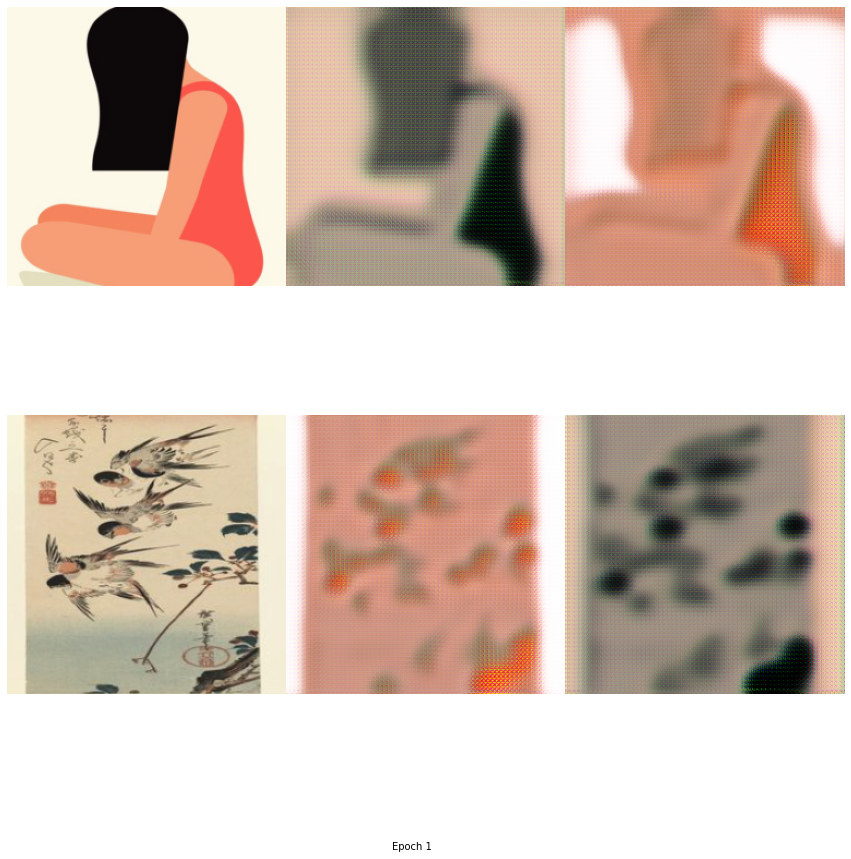

Epoch [2/100], Step [1/100], D_A_loss: 0.2855, D_B_loss: 0.2606, G_A_loss: 0.4204, G_B_loss: 0.2744


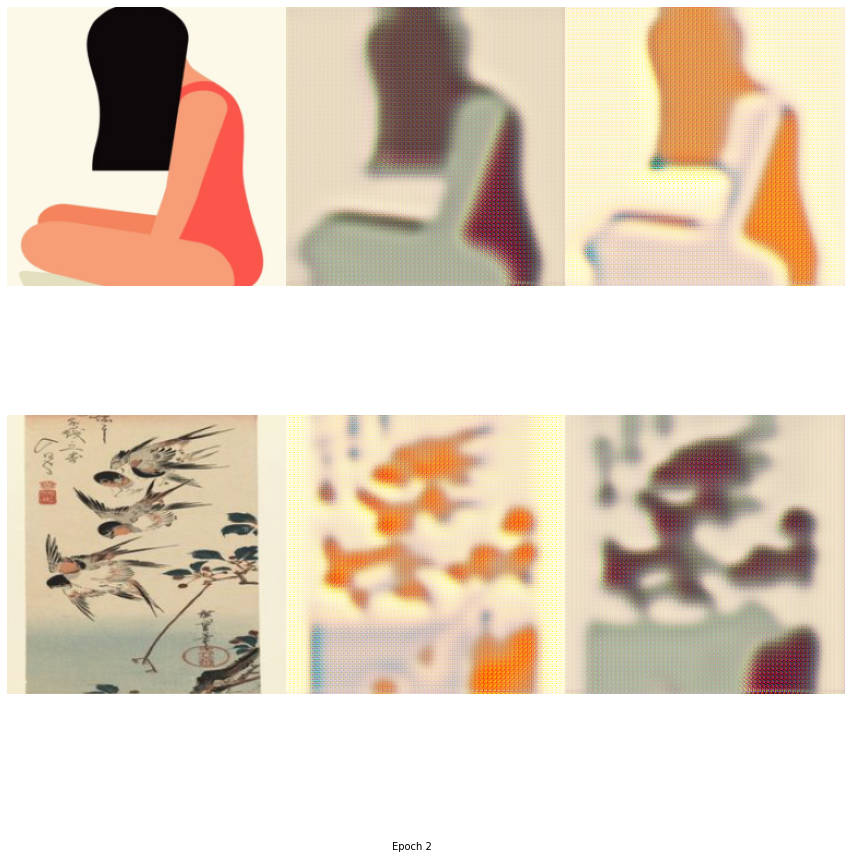

Epoch [3/100], Step [1/100], D_A_loss: 0.2317, D_B_loss: 0.2053, G_A_loss: 0.2213, G_B_loss: 0.6968


KeyboardInterrupt: ignored

In [17]:


# Generated image pool
num_pool = 50
fake_A_pool = ImagePool(num_pool)
fake_B_pool = ImagePool(num_pool)

step = 0
for epoch in range(params['num_epochs']):
    D_A_losses = []
    D_B_losses = []
    G_A_losses = []
    G_B_losses = []
    cycle_A_losses = []
    cycle_B_losses = []
    
    # Learing rate decay 
    if(epoch + 1) > params['decay_epoch']:
        D_A_optimizer.param_groups[0]['lr'] -= params['lrD'] / (params['num_epochs'] - params['decay_epoch'])
        D_B_optimizer.param_groups[0]['lr'] -= params['lrD'] / (params['num_epochs'] - params['decay_epoch'])
        G_optimizer.param_groups[0]['lr'] -= params['lrG'] / (params['num_epochs'] - params['decay_epoch'])
        
    
    # training 
    for i, (real_A, real_B) in enumerate(zip(train_data_loader_A, train_data_loader_B)):
        
        # input image data
        real_A = real_A.to(device)
        real_B = real_B.to(device)
        
        # -------------------------- train generator G --------------------------
        # A --> B
        fake_B = G_A(real_A)
        D_B_fake_decision = D_B(fake_B)
        G_A_loss = MSE_Loss(D_B_fake_decision, Variable(torch.ones(D_B_fake_decision.size()).cuda()))
        
        # forward cycle loss
        recon_A = G_B(fake_B)
        cycle_A_loss = L1_Loss(recon_A, real_A) * params['lambdaA']
        
        # B --> A
        fake_A = G_B(real_B)
        D_A_fake_decision = D_A(fake_A)
        G_B_loss = MSE_Loss(D_A_fake_decision, Variable(torch.ones(D_A_fake_decision.size()).cuda()))
        
        # backward cycle loss
        recon_B = G_A(fake_A)
        cycle_B_loss = L1_Loss(recon_B, real_B) * params['lambdaB']
        
        # Back propagation
        G_loss = G_A_loss + G_B_loss + cycle_A_loss + cycle_B_loss
        G_optimizer.zero_grad()
        G_loss.backward()
        G_optimizer.step()
        
        
        # -------------------------- train discriminator D_A --------------------------
        D_A_real_decision = D_A(real_A)
        D_A_real_loss = MSE_Loss(D_A_real_decision, Variable(torch.ones(D_A_real_decision.size()).cuda()))
        
        fake_A = fake_A_pool.query(fake_A)
        
        D_A_fake_decision = D_A(fake_A)
        D_A_fake_loss = MSE_Loss(D_A_fake_decision, Variable(torch.zeros(D_A_fake_decision.size()).cuda()))
        
        # Back propagation
        D_A_loss = (D_A_real_loss + D_A_fake_loss) * 0.5
        D_A_optimizer.zero_grad()
        D_A_loss.backward()
        D_A_optimizer.step()
        
        # -------------------------- train discriminator D_B --------------------------
        D_B_real_decision = D_B(real_B)
        D_B_real_loss = MSE_Loss(D_B_real_decision, Variable(torch.ones(D_B_fake_decision.size()).cuda()))
        
        fake_B = fake_B_pool.query(fake_B)
        
        D_B_fake_decision = D_B(fake_B)
        D_B_fake_loss = MSE_Loss(D_B_fake_decision, Variable(torch.zeros(D_B_fake_decision.size()).cuda()))
        
        # Back propagation
        D_B_loss = (D_B_real_loss + D_B_fake_loss) * 0.5
        D_B_optimizer.zero_grad()
        D_B_loss.backward()
        D_B_optimizer.step()
        
        # ------------------------ Print -----------------------------
        # loss values
        D_A_losses.append(D_A_loss.item())
        D_B_losses.append(D_B_loss.item())
        G_A_losses.append(G_A_loss.item())
        G_B_losses.append(G_B_loss.item())
        cycle_A_losses.append(cycle_A_loss.item())
        cycle_B_losses.append(cycle_B_loss.item())

        if i%100 == 0:
            print('Epoch [%d/%d], Step [%d/%d], D_A_loss: %.4f, D_B_loss: %.4f, G_A_loss: %.4f, G_B_loss: %.4f'
                  % (epoch+1, params['num_epochs'], i+1, len(train_data_loader_A), D_A_loss.item(), D_B_loss.item(), G_A_loss.item(), G_B_loss.item()))
            
        step += 1
        
    D_A_avg_loss = torch.mean(torch.FloatTensor(D_A_losses))
    D_B_avg_loss = torch.mean(torch.FloatTensor(D_B_losses))
    G_A_avg_loss = torch.mean(torch.FloatTensor(G_A_losses))
    G_B_avg_loss = torch.mean(torch.FloatTensor(G_B_losses))
    cycle_A_avg_loss = torch.mean(torch.FloatTensor(cycle_A_losses))
    cycle_B_avg_loss = torch.mean(torch.FloatTensor(cycle_B_losses))

    # avg loss values for plot
    D_A_avg_losses.append(D_A_avg_loss.item())
    D_B_avg_losses.append(D_B_avg_loss.item())
    G_A_avg_losses.append(G_A_avg_loss.item())
    G_B_avg_losses.append(G_B_avg_loss.item())
    cycle_A_avg_losses.append(cycle_A_avg_loss.item())
    cycle_B_avg_losses.append(cycle_B_avg_loss.item())
    
    # Show result for test image
    test_real_A = test_real_A_data.cuda()
    test_fake_B = G_A(test_real_A)
    test_recon_A = G_B(test_fake_B)

    test_real_B = test_real_B_data.cuda()
    test_fake_A = G_B(test_real_B)
    test_recon_B = G_A(test_fake_A)

    plot_train_result([test_real_A, test_real_B], [test_fake_B, test_fake_A], [test_recon_A, test_recon_B],
                            epoch, save=True)

all_losses = pd.DataFrame()
all_losses['D_A_avg_losses'] = D_A_avg_losses
all_losses['D_B_avg_losses'] = D_B_avg_losses
all_losses['G_A_avg_losses'] = G_A_avg_losses
all_losses['G_B_avg_losses'] = G_B_avg_losses
all_losses['cycle_A_avg_losses'] = cycle_A_avg_losses
all_losses['cycle_B_avg_losses'] = cycle_B_avg_losses
all_losses.to_csv('avg_losses',index=False)